
### Търсене и извличане на информация. Приложение на дълбоко машинно обучение
### Стоян Михов
### Зимен семестър 2025/2026

## Упражнение 10

За да работи програмата трябва корпуса от публицистични текстове за Югоизточна Европа,
да се намира разархивиран в наддиректорията, в която е програмата (виж упражнение 2).

Преди да се стартира програмата е необходимо да се активира съответното обкръжение с командата:
conda activate tii

In [1]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import sys
import random
import math
import pprint

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
from sklearn.decomposition import TruncatedSVD

In [2]:
class progressBar:
    def __init__(self ,barWidth = 50):
        self.barWidth = barWidth
        self.period = None
    def start(self, count):
        self.item=0
        self.period = int(count / self.barWidth)
        sys.stdout.write("["+(" " * self.barWidth)+"]")
        sys.stdout.flush()
    def tick(self):
        if self.item>0 and self.item % self.period == 0:
            progress = self.item // self.period
            sys.stdout.write(f"\r[{'-'* progress}{' '*(self.barWidth - progress)}]")
            sys.stdout.flush()
        self.item += 1
    def stop(self):
        sys.stdout.write("\r["+("-" * self.barWidth)+"]\n")

###  Разбиване на корпус на тестов и тренинг

In [3]:
def splitSentCorpus(fullSentCorpus, testFraction = 0.1):
    random.seed(42)
    random.shuffle(fullSentCorpus)
    testCount = int(len(fullSentCorpus) * testFraction)
    testSentCorpus = fullSentCorpus[:testCount]
    trainSentCorpus = fullSentCorpus[testCount:]
    return testSentCorpus, trainSentCorpus

In [4]:
startToken = '<START>'
endToken = '<END>'
unkToken = '<UNK>'

In [5]:
def extractDictionary(corpus, limit=20000):
    pb = progressBar()
    pb.start(len(corpus))
    dictionary = {}
    for doc in corpus:
        pb.tick()
        for w in doc:
            if w not in dictionary: dictionary[w] = 0
        dictionary[w] += 1
    L = sorted([(w,dictionary[w]) for w in dictionary], key = lambda x: x[1] , reverse=True)
    if limit > len(L): limit = len(L)
    words = [ w for w,_ in L[:limit] ]
    word2ind = { w:i for i,w in enumerate(words)}
    pb.stop()
    for tok in [startToken, endToken, unkToken]:
        if tok not in word2ind:
            word2ind[tok] = len(word2ind)
            words.append(tok)
    return words, word2ind



Обектна имплементация на Backpropagation с Numpy операции
####

In [6]:
class compNode:
    def __init__(self, predecessors, trainable = True):
        self.predecessors = predecessors
        self.trainable = trainable
        self.value = None
        self.grad = None
    
    def calcValue(self): ## трябва да се дефинира за конкретния връх като се извика setValue
        return
    
    def propagateGrad(self, grad):
        if not self.grad:
            self.grad = grad
        else:
            self.grad += grad

    def derivativeMult(self,i): ## трябва да се дефинира за конкретния връх
        return
    
    def propagateBack(self):
        if not self.predecessors: return
        for i,p in enumerate(self.predecessors):
            if p.trainable:
                partialGrad = self.derivativeMult(i)
                p.propagateGrad(partialGrad)

In [7]:
def getSortedNodes(t,L):
    if t in L: return L
    if t.predecessors:
        for p in t.predecessors:
            L = getSortedNodes(p,L)
    L.append(t)
    return L

#### Базов обект за модел на невронна мрежа
#### Съдържа имплементация на Backpropagation
#### и стохастично спускане по градиента

![alt text](CBOW_word2vec_as_an_autoencoder.svg)

In [8]:
class model:
    def __init__(self, topNode):
        self.topNode = topNode
        self.sortedNodes = getSortedNodes(topNode,[])
        self.paramNodes = [ v for v in self.sortedNodes if v.trainable and not v.predecessors ]
        self.dataNodes = [ v for v in self.sortedNodes if not v.trainable and not v.predecessors ]
    
    def setParameters(self, params):
        for i, p in enumerate(params):
            self.paramNodes[i].value = p

    def setData(self, data):
        for i, d in enumerate(data):
            self.dataNodes[i].value = d

    def saveModelParams(self, fileName):
        with open(fileName, 'wb') as f:
            for p in self.paramNodes:
                np.save(f, p.value)

    def loadModelParams(self, fileName):
        with open(fileName, 'rb') as f:
            for p in self.paramNodes:
                p.value = np.load(f, allow_pickle=True)

    def forward(self):
        for v in self.sortedNodes:
            v.calcValue()

    def backwards(self):
        for v in self.sortedNodes:
            v.grad = None
        self.topNode.propagateGrad(1)
        for v in reversed(self.sortedNodes):
            v.propagateBack()
                
    def updateModel(self,alpha):
        for p in self.paramNodes:
            p.value -= alpha * p.grad
    
    def calcLoss(self,testData,batchSize):
        loss = 0.
        samples = len(testData[0])
        for i in range(0,samples,batchSize):
            li = min(i+batchSize, samples)
            batchData = [d[i:li] for d in testData ]
            self.setData(batchData)
            self.forward()
            loss += (li-i) * self.topNode.value
        return loss / samples
    
    def batchedStochasticGradient(self, trainData, testData, batchSize, alpha = 1., maxStep = 100000, printInterval = 1000, saveInterval = 10000, fileToSave = None):
        ceList = []
        tceList = []
        epoch = 0
        step = 0
        samples = np.arange(trainData[0].shape[0], dtype='int32')
        while True:
            np.random.shuffle(samples)
            for i in range(0,len(samples),batchSize):
                if fileToSave and step > 0 and step % saveInterval == 0:
                    print("Saving model at step: ",step)
                    self.saveModelParams(fileToSave)
                if step % printInterval == 0:
                    ce = self.topNode.value
                    tce = self.calcLoss(testData,batchSize)
                    print("Epoch: ",epoch, ", step: ",step, ", train error: ", ce, ", test error: ",tce)
                    ceList.append(ce)
                    tceList.append(tce)

                idx = samples[i:min(i+batchSize, len(samples))]
                batchData = [d[idx] for d in trainData ]
                self.setData(batchData)
                self.forward()
                self.backwards()
                self.updateModel(alpha)
                step += 1
                if step >= maxStep: return ceList, tceList
            epoch += 1


In [9]:
class termFrequencyNode(compNode):
    # преобразува всеки контекст в честотен вектор
    def setDictionarySize(self,size):
        self.dictionarySize = size
    def calcValue(self):
        ### c следва да бъде списък от контексти с индекси
        c = self.predecessors[0].value
        S = len(c)
        self.value = np.zeros((S,self.dictionarySize), dtype = 'int32')
        for i in range(S):
            for j in c[i]:
                self.value[i,j] += 1

In [10]:
class mulMatrixMatrixNode(compNode):
    def calcValue(self):
        x = self.predecessors[0].value
        y = self.predecessors[1].value
        self.value = np.dot(x,y)
    def derivativeMult(self,i):
        if i == 0:
            y = self.predecessors[1].value
            return np.dot(self.grad,y.transpose())
        else:
            x = self.predecessors[0].value
            return np.dot(x.transpose(),self.grad)

In [11]:
def softmaxM(U):
    ### U следва да бъде матрица с размерност: (S,M)
    U = np.exp(U)
    tmp = np.sum(U,axis=1)[:,np.newaxis] # (S,1)
    U /= tmp
    return U #(S,M)

In [12]:
class crossEntropySoftmaxNode(compNode):
    def calcValue(self):
        ### t следва да бъде матрица с размерност: (S,M)
        ### w следва да бъде вектор с размерност S от индекси на думи
        t = self.predecessors[0].value
        w = self.predecessors[1].value
        self.S = t.shape[0]
        self.v = softmaxM(t)
        p = self.v[np.arange(self.S, dtype='int32'),w]
        self.value = -np.mean(np.log(p))
    def derivativeMult(self,i):
        w = self.predecessors[1].value
        d = self.v
        d[np.arange(self.S, dtype='int32'),w] -= 1.
        return self.grad * (d/self.S)

In [13]:
def extractContexts(corpus, window_size_left, window_size_right, words, word2ind):
    pb = progressBar()
    pb.start(len(corpus))
    unk = word2ind[unkToken]

    centers = []
    contexts = []
    for doc in corpus:
        pb.tick()
        for wi in range(len(doc)):
            i = word2ind.get(doc[wi], unk)
            context = []
            for k in range(1,window_size_left+1):
                if wi-k>=0:
                    j = word2ind.get(doc[wi-k], unk)
                    context.append(j)
            for k in range(1,window_size_right+1):
                if wi+k<len(doc):
                    j = word2ind.get(doc[wi+k], unk)
                    context.append(j)
            if len(context)==0: continue
            centers.append(i)
            contexts.append(context)
    pb.stop()
    return np.array(centers, dtype = 'int32'),np.array(contexts, dtype=object)

In [14]:
corpus_root = '../JOURNALISM.BG/C-MassMedia'
myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')

corpus = [ [startToken] + [w.lower() for w in sent] + [endToken] for sent in myCorpus.sents()]

words, word2ind = extractDictionary(corpus)

testCorpus, trainCorpus = splitSentCorpus(corpus)

window_size = 4
trainW, trainC = extractContexts(trainCorpus, window_size, window_size, words, word2ind)
testW, testC = extractContexts(testCorpus, window_size, window_size, words, word2ind)


<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Rumen\AppData\Local\Temp\ipykernel_31884\711016388.py:2: SyntaxWarning: invalid escape sequence '\.'
  myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')


[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]


In [15]:
w = compNode(None,trainable=False)
C = compNode(None,trainable=False)
U = compNode(None)
V = compNode(None)
chi = termFrequencyNode([C],trainable=False)
chi.setDictionarySize(len(words))
VC = mulMatrixMatrixNode([chi,V])
Z = mulMatrixMatrixNode([VC,U])
h = crossEntropySoftmaxNode([Z,w])

In [16]:

embDim = 50
U0 = (np.random.rand(embDim, len(words)) - 0.5) / embDim
V0 = (np.random.rand(len(words), embDim) - 0.5) / embDim

word2vec = model(h)
word2vec.setParameters([np.copy(V0),np.copy(U0)])

In [17]:
cefList, tcefList = word2vec.batchedStochasticGradient([trainC,trainW], [testC[:1000],testW[:1000]], 100, maxStep = 94001, printInterval = 100, saveInterval = 1000, fileToSave = 'test.save')

# Ако имаме вече натрениран модел може директно да го заредим
#   word2vec.loadModelParams('w2v.params')
#

Epoch:  0 , step:  0 , train error:  None , test error:  9.903487952708582
Epoch:  0 , step:  100 , train error:  8.963973762947285 , test error:  8.01435438689792
Epoch:  0 , step:  200 , train error:  6.811328871804172 , test error:  6.65899185426069
Epoch:  0 , step:  300 , train error:  6.26012120426808 , test error:  6.382176635455815
Epoch:  0 , step:  400 , train error:  6.627078095597575 , test error:  6.090553667494208
Epoch:  0 , step:  500 , train error:  6.433789101294643 , test error:  6.005325635979933
Epoch:  0 , step:  600 , train error:  6.2087776235696905 , test error:  5.896263698823502
Epoch:  0 , step:  700 , train error:  5.755351161198282 , test error:  5.870576678666542
Epoch:  0 , step:  800 , train error:  5.940433721488838 , test error:  5.7367664511445575
Epoch:  0 , step:  900 , train error:  5.795745634433933 , test error:  5.714199171027196
Saving model at step:  1000
Epoch:  0 , step:  1000 , train error:  5.9880260746943375 , test error:  5.685169453023

In [28]:
word2vec.saveModelParams('w2v.params')

In [18]:
# word2vec.loadModelParams('w2v.params')

In [19]:
# E = V.value
# E = U.value.transpose()
E = np.concatenate([U.value.transpose(),V.value],axis=1)

In [20]:
def SVD_k_dim(X, k=100, n_iters = 10):
    # Документация на метода има на https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
    print("Running Truncated SVD over %i words..." % (X.shape[0]))
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    svd.fit(X)
    X_reduced = svd.transform(X)
    print("Done.")
    return X_reduced

def plot_embeddings_3d(M, word2ind, words):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    xs = M[:,0]
    ys = M[:,1]
    zs = M[:,2]
    for w in words:
        i=word2ind[w]
        ax.scatter(xs[i], ys[i], zs[i], marker='x', color= 'red')
        ax.text(xs[i]+0.001, ys[i]+0.001, zs[i]+0.001, w)
    plt.show()

In [21]:
def plot_embeddings_pairs_3d(M, word2ind, wordPairs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    xs = M[:,0]
    ys = M[:,1]
    zs = M[:,2]
    for u,v in wordPairs:
        i=word2ind[u]
        j=word2ind[v]
        ax.plot(xs[[i,j]], ys[[i,j]], zs[[i,j]], color= 'red')
        ax.text(xs[i]+0.001, ys[i]+0.001, zs[i]+0.001, u)
        ax.text(xs[j]+0.001, ys[j]+0.001, zs[j]+0.001, v)
    plt.show()

Running Truncated SVD over 20001 words...
Done.


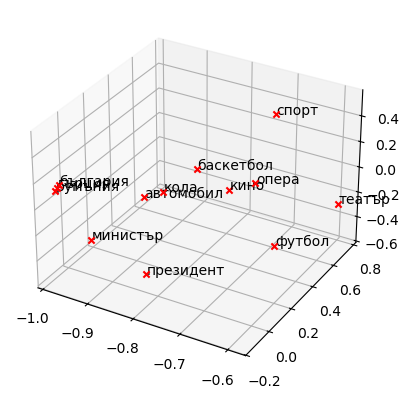

In [22]:
E_reduced =SVD_k_dim(E,k=3)
E_normalized_3d = E_reduced /np.linalg.norm(E_reduced, axis=1)[:, np.newaxis]
sampleWords = ['кола', 'автомобил', 'румъния', 'министър', 'президент', 'гърция', 'футбол', 'спорт', 'баскетбол', 'българия', 'театър', 'кино', 'опера']

plot_embeddings_3d(E_normalized_3d, word2ind, sampleWords)

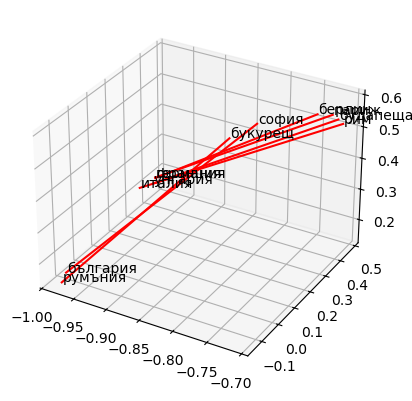

In [23]:
sampleWordPairs = [('румъния', 'букурещ'), ('италия', 'рим'), ('франция', 'париж'), ('унгария', 'будапеща'), ('българия', 'софия'), ('германия', 'берлин')]

plot_embeddings_pairs_3d(E_normalized_3d, word2ind, sampleWordPairs)


In [24]:
E_normalized = E /np.linalg.norm(E, axis=1)[:, np.newaxis]

def most_similar(w,word2ind,words,C,limit=10):
    i = word2ind[w]
    L = np.dot(C,C[i]).tolist()
    L = sorted([(words[i],s) for i,s in enumerate(L)], key = lambda x: x[1] , reverse=True)
    return L[:limit]

pprint.pprint(most_similar('гърция',word2ind,words,E_normalized,limit=5))
pprint.pprint(most_similar('футбол',word2ind,words,E_normalized,limit=5))
pprint.pprint(most_similar('град',word2ind,words,E_normalized,limit=5))
pprint.pprint(most_similar('съд',word2ind,words,E_normalized,limit=5))


[('гърция', 1.0),
 ('израел', 0.7353581252163628),
 ('армения', 0.7250329551447693),
 ('иран', 0.7068704325256376),
 ('катар', 0.7020790430204407)]
[('футбол', 1.0),
 ('хандбал', 0.882235268745245),
 ('баскетбол', 0.8686174296788141),
 ('топка', 0.8627565750628757),
 ('водна', 0.8379896483264941)]
[('град', 0.9999999999999998),
 ('курорт', 0.7648142163898816),
 ('село', 0.7643890700382867),
 ('район', 0.7415453512731356),
 ('остров', 0.7166856149173428)]
[('съд', 1.0),
 ('съвет', 0.7079449771063582),
 ('парламент', 0.6878477601470465),
 ('съда', 0.6493730469130703),
 ('състав', 0.639534983497967)]


In [25]:
print('Перплексията(↓) на Word2Vec CBOW модела е: ', np.exp(word2vec.calcLoss([testC[:100000],testW[:100000]],100)))



Перплексията(↓) на Word2Vec CBOW модела е:  48.29968530248798


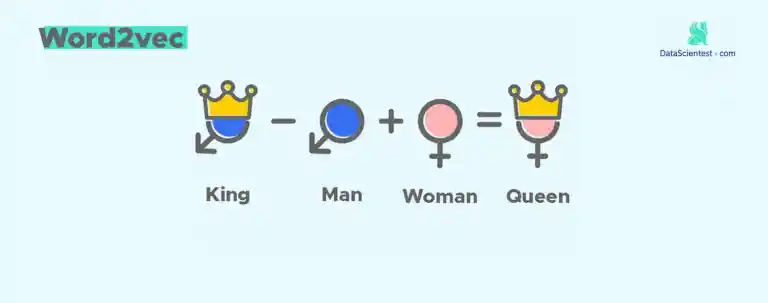

In [26]:
def analogy(positive,negative,word2ind,words,C,limit=10):
    p = np.sum([C[word2ind[w]] for w in positive], axis = 0)
    n = np.sum([C[word2ind[w]] for w in negative], axis = 0)
    L = np.dot(C,(p-n)).tolist()
    L = sorted([(words[i],s) for i,s in enumerate(L)], key = lambda x: x[1] , reverse=True)
    return L[:limit]

pprint.pprint(analogy(['букурещ','германия'],['румъния'],word2ind,words,E_normalized,limit=5))
pprint.pprint(analogy(['букурещ','гърция'],['румъния'],word2ind,words,E_normalized,limit=5))
pprint.pprint(analogy(['букурещ','албания'],['румъния'],word2ind,words,E_normalized,limit=5))
pprint.pprint(analogy(['тирана','италия'],['албания'],word2ind,words,E_normalized,limit=5))
pprint.pprint(analogy(['атина','германия'],['гърция'],word2ind,words,E_normalized,limit=5))
pprint.pprint(analogy(['гърция','софия'],['атина'],word2ind,words,E_normalized,limit=5))

pprint.pprint(analogy(['левски','мюнхен'],['софия'],word2ind,words,E_normalized,limit=5))
pprint.pprint(analogy(['министър','мъж'],['жена'],word2ind,words,E_normalized))

[('букурещ', 1.2996985673157517),
 ('българия', 0.9264185414415882),
 ('австрия', 0.9210907692319714),
 ('париж', 0.9201714293353177),
 ('лондон', 0.9195837479603772)]
[('букурещ', 1.3139969973805248),
 ('българия', 0.9036015547154452),
 ('скопие', 0.8374306987170266),
 ('тирана', 0.810198619451743),
 ('гърция', 0.8068694595746659)]
[('букурещ', 1.2259035744603273),
 ('българия', 0.8683376511928615),
 ('загреб', 0.8240024370895602),
 ('скопие', 0.7914917953533149),
 ('местните', 0.7420421853370289)]
[('тирана', 1.0844295492878582),
 ('любляна', 0.8998556468593674),
 ('tирана', 0.8711088630134459),
 ('италия', 0.8511773322146488),
 ('швеция', 0.8264624898579034)]
[('атина', 1.0347854583117808),
 ('германия', 0.93332466511239),
 ('париж', 0.8686814115457843),
 ('лондон', 0.85994460636073),
 ('aтина', 0.8476919085857698)]
[('гърция', 1.038107977002736),
 ('софия', 0.9926745490360429),
 ('румъния', 0.9294452193069457),
 ('катар', 0.7975904030324663),
 ('бразилия', 0.7650746878293326)]
[('л